# Time Series Analysis and Fourier Methods


## GeoInfo Tutorial Outline

1. Some initial intuition on the FFT
2. Computing the PSD (or amplitude spectrum)
3. Good Practices to dealing with Fourier transforms
4. **Cross-correlation**
5. **Deconvolution**

### Instructor: Germán A. Prieto (gaprietogo@unal.edu.co)

#### Import basic packages that we will use. 

In [2]:
import numpy as np
import scipy
import scipy.signal as signal
import matplotlib.pyplot as plt
import obspy
from obspy.clients.fdsn import Client

## Example 4. Spectral analysis of seismic data in California

In the last few 15-20 years, seismologist  have started to extract more and more information from the *noise*. From tracking storms, to performing 3D seismic tomography using surface waves, it is today a *standard tool*.

We will work with 24-hour of data from two seismic stations in California (PASC and ADO). They are separated about 150 km and record the ambient seismic field. I chose a particular day (randomly), but this should more or less work if you choose any other day of the year, **except if you have a large earthquake in the middle**. 

You should have access to the data ``pasc.mseed`` and ``ado.mseed`` in your folder, but if not, just remove comments to download the data. Data is instrument corrected to velocity.

In [3]:
# Edit client to use your data center of interest
#client = Client("IRIS")
#client = Client("SCEDC")
#t1 = obspy.UTCDateTime("2010-04-01")
#starttime = t1
#endtime = t1 + 24*60*60  # 24 hours of data
#
#net = "CI"
#sta = "PASC"
#loc = "00"
#chan = "LHZ"
#st1 = client.get_waveforms(net, sta, loc, chan, starttime, endtime, attach_response = True)
#st1.remove_response(output = 'VEL')
#
#net  = "CI"
#sta  = "ADO"
#loc  = "*"
#chan = "LHZ"
#st2  = client.get_waveforms(net, sta, loc, chan, starttime, endtime, attach_response = True)
#st2.remove_response(output = 'VEL')
#
#st1.write("pasc.mseed", format="MSEED")  
#st2.write("ado.mseed", format="MSEED")  

st1 = obspy.read('pasc.mseed')
st2 = obspy.read('ado.mseed') 
print(st1)
print(st2)



1 Trace(s) in Stream:
CI.PASC.00.LHZ | 2010-04-01T00:00:00.069400Z - 2010-04-01T23:59:59.069400Z | 1.0 Hz, 86400 samples
1 Trace(s) in Stream:
CI.ADO..LHZ | 2010-04-01T00:00:00.690700Z - 2010-04-01T23:59:59.690700Z | 1.0 Hz, 86400 samples


**Plot filtered traces** 

(8.0, 9.0)

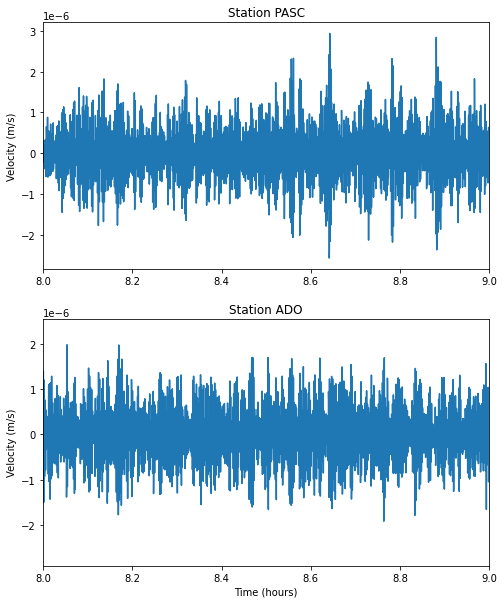

In [6]:
tr1    = st1[0]
pasc   = tr1.data
tr2    = st2[0]
ado    = tr2.data
dt4    = tr1.stats.delta
nx4    = tr1.stats.npts   
t      = np.arange(nx4)*dt4 

#------------------------------------------
# Create a Butterworth filter
#   Define nyquist and scale frequencies
#------------------------------------------
fmin = 0.01
fmax = 0.4
fnyq = 0.5/dt4
f0   = fmin/fnyq
f1   = fmax/fnyq
wn   = [f0,f1]

#-------------------------------------------------
# Create filter, and apply filter to both traces
#-------------------------------------------------
b,a = signal.butter(4, wn, 'bandpass')
x4  = signal.filtfilt(b,a,pasc)
y4  = signal.filtfilt(b,a,ado)

# Plot data
fig = plt.figure(figsize = (8,10))
ax = fig.add_subplot(211)
ax.plot(t/3600,x4)
ax.set_ylabel('Velocity (m/s)');
ax.set_title('Station PASC')
ax2 = fig.add_subplot(212)
ax2.plot(t/3600,y4)
ax2.set_xlabel('Time (hours)');
ax2.set_ylabel('Velocity (m/s)');
ax2.set_title('Station ADO');
ax.set_xlim((8,9))
ax2.set_xlim((8,9))


#### Now, compute the PSD

- Do not compute the PSD on the filtered trace, but rather the raw data.
- Get variance, to normalize the spectrum $S(f)$.
- Because of the variance of spectral estimates, smoothing is necesary. We do this using a running window convolution. It is a rough way to do it, you can choose better ways. 



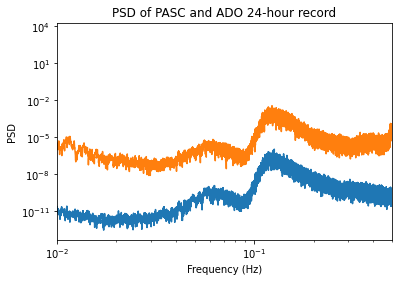

In [5]:
x4    = signal.detrend(pasc,type='constant')
y4    = signal.detrend(ado, type='constant')
xvar4 = np.var(x4)
yvar4 = np.var(y4)

# Calculate PSD (hanning taper), with padding. 
npts   = nx4
npts2  = 2*npts+1   # make padding odd. 
nf4    = int((npts2+1)/2)   
hann   = np.hanning(npts)
freq4  = scipy.fft.fftfreq(npts2,dt4)
df4    = freq4[1]

# Taper signals
dat_x4         = np.zeros(npts2)
dat_x4[0:npts] = x4*hann
dat_y4         = np.zeros(npts2)
dat_y4[0:npts] = y4*hann

# Get PSD, for ease we will not normalize.  
fx4   = scipy.fft.fft(dat_x4,npts2)
Px4   = abs(fx4)**2
fy4   = scipy.fft.fft(dat_y4,npts2)
Py4   = abs(fy4)**2

# Apply a smoothing operator, improve variance. 
nsmooth = 10
Px4_smooth = np.convolve(Px4, np.ones(nsmooth)/nsmooth)
Py4_smooth = np.convolve(Py4, np.ones(nsmooth)/nsmooth)

# Plot results
fig = plt.figure()
ax = fig.add_subplot(111)
ax.loglog(abs(freq4[0:nf4]),Px4_smooth[0:nf4])
ax.loglog(abs(freq4[0:nf4]),Py4_smooth[0:nf4]*5000)
#ax.set_ylim(1e-18, 1e-6);
ax.set_xlim(0.01, 0.5);
ax.set_xlabel('Frequency (Hz)');
ax.set_ylabel('PSD');
ax.set_title('PSD of PASC and ADO 24-hour record');

### Let's do some ambient noise stuff (could be earthquake source problems, receiver functions)

The basic idea of Ambient Noise Tomography (ANT) is that by computing the cross-correlation of the records at two stations (given some important requirements that will not be discussed here)you obtain a waveform this is proportional to the Green's function between the two stations. 

In the frequency domain, the cross-spectrum
\begin{equation}
S_{xy} = \hat{X}(f)*\hat{Y}^\ast(f)
\end{equation}
where the $Y^\ast$ represents the complex-conjugate of $Y$.

Note that unlike the power spectra
\begin{equation}
S_{xx} = \hat{X}(f)*\hat{X}^\ast(f)
\end{equation}

the cross-spectrum is complex-valued. If you take the iFFT of the cross-spectrum, it is equivalent to the cross-correlation between two signals in the time domain. 

The codes below try to show you how the correlation function can be obtained using the FFT. As you will see, some sort of normalization is needed. For example, Bensen et al. (200?) suggest to prewhiten the signals before correlation, that is
\begin{equation}
X_{norm}(f) = \frac{\hat{X}(f)}{\sqrt{<S_{xx}(f)>}}
\end{equation}
where the $<\cdot>$ represents some sort of averaged, or smoothed version of the term inside. Similar for $Y$, and then calculate the cross spectrum. 

This is equivalent to what is known as the coherency:
\begin{equation}
C_{xy}(f) = \frac{S_{xy}(f)}{\sqrt{<S_{xx}(f)><S_{yy}(f)>}}
\end{equation}

In various studies, people have use deconvolution instead of correlations (cross-spectra) or normalized correlations (coherency). We proposed this a while ago (Prieto and Beroza, 2008; Denolle et al., 2013) to be able to "see" amplification effects of basins using noise. In buildings Roel Snieder, Maria Todorovska, Monica Kohler, Nori Nakata, my group and others have used decolvolution interferometry with great success. Deconvolution is also used in Receiver functions, earthquake source studies (source time function estimation), and in many other fields of seismology and geophysics.  

In the frequency domain, the convolution is equivalent to multiplication, thus the deconvolution is just division. We call this the transfer function and could (naively) calculated using
\begin{equation}
T_{xy}(f) = \frac{X(f)}{Y(f)}
\end{equation}
which is a complex-valued function. Take the iFFT, and you get the deconvolution or impulse response. 

A better way to compute the deconvolution, just multiple by $Y^\ast$ above and below
\begin{equation}
T_{xy}(f) = \frac{X(f)Y^\ast(f)}{Y(f)Y^\ast(f)}=\frac{S_{xy}(f)}{<S_{yy}(f)>} 
\end{equation}
If you want even more stability to the deconvol;ution (avoid dividing by zero) add a water-level
\begin{equation}
T_{xy}(f) = \frac{S_{xy}(f)}{<S_{yy}>(f)+W_L} 
\end{equation}



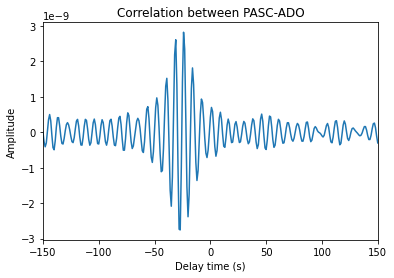

In [7]:
# Compute the cross spectrum, ifft to get cross-correlation
Sxy    = fx4*np.conj(fy4)
xycorr = np.real(scipy.fft.ifft(Sxy))
xycorr = scipy.fft.ifftshift(xycorr)

# Delay time vector
tdel  = np.linspace(-nf4,nf4,npts2)

# Filter cross-correlation
fmin = 0.05
fmax = 0.4
fnyq = 0.5/dt4
f0   = fmin/fnyq
f1   = fmax/fnyq
wn   = [f0,f1] 
b, a = signal.butter(4, wn,'bandpass')
xycorr_filt = signal.filtfilt(b, a, xycorr)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(tdel,xycorr_filt)
ax.set_xlim(-150, 150);
ax.set_xlabel('Delay time (s)');
ax.set_ylabel('Amplitude');
ax.set_title('Correlation between PASC-ADO');

#### Notes

Results are very monocromathic, why?
This would be very hard for dispersion analysis.

#### Let's look at its spectrum.

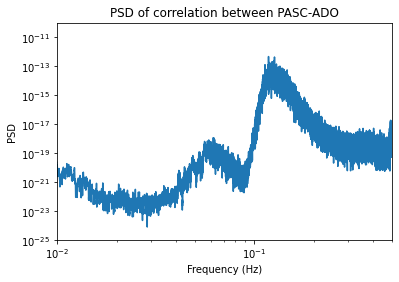

In [6]:
ft_xycorr     = scipy.fft.fft(xycorr,npts2)
ft_xycorr     = abs(ft_xycorr)**2
xycorr_smooth = np.convolve(ft_xycorr, np.ones(nsmooth)/nsmooth)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.loglog(abs(freq4[0:nf4]),xycorr_smooth[0:nf4])
ax.set_ylim(1e-25, 1e-10);
ax.set_xlim(0.01, 0.5);
ax.set_xlabel('Frequency (Hz)');
ax.set_ylabel('PSD');
ax.set_title('PSD of correlation between PASC-ADO');

### Compute the normalized correlation instead (coherency)

To get a better behaved, broad band GF, we normalize the the PSD of both signals. In principle, similar to Bensen et al. 

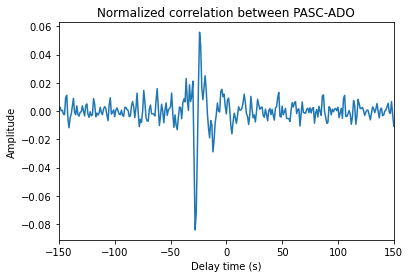

In [8]:
#---------------------------------------------------------------------
# Compute the coherence, ifft to get cross-correlation, normalized
#---------------------------------------------------------------------
Sxy         = fx4*np.conj(fy4)
cohe        = Sxy/(np.sqrt(Px4_smooth[0:npts2])*np.sqrt(Py4_smooth[0:npts2]))
xycorr_norm = np.real(scipy.fft.ifft(cohe))
xycorr_norm = scipy.fft.ifftshift(xycorr_norm)

#----------------------------------------------------
# Filter norm. correlation
#----------------------------------------------------
ccorr_norm_filt = signal.filtfilt(b, a, xycorr_norm)

#----------------------------------------------------
# Plot norm correlation
#----------------------------------------------------
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(tdel,ccorr_norm_filt)
ax.set_xlim(-150, 150);
ax.set_xlabel('Delay time (s)');
ax.set_ylabel('Amplitude');
ax.set_title('Normalized correlation between PASC-ADO');


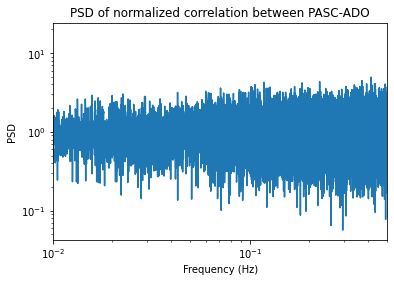

In [9]:
ft_cohe  = scipy.fft.fft(xycorr_norm,npts2)
ft_cohe  = abs(ft_cohe)**2
cohe_smooth = np.convolve(ft_cohe, np.ones(nsmooth)/nsmooth)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.loglog(abs(freq4[0:nf4]),cohe_smooth[0:nf4])
ax.set_xlim(0.01, 0.5)
ax.set_xlabel('Frequency (Hz)');
ax.set_ylabel('PSD');
ax.set_title('PSD of normalized correlation between PASC-ADO');

### Deconvolution interferometry 

Because there was a questions about this, let's add a water-level, to stabilize the deconvolution. 

We will try the three ways of deconvolution noted here (there are many opther methods. I personally prefer the multitaper method, but that is me. 

- Method 1
\begin{equation}
T_{xy}(f) = \frac{X(f)}{Y(f)}
\end{equation}

- Method 2
\begin{equation}
T_{xy}(f) = \frac{X(f)Y^\ast(f)}{Y(f)Y^\ast(f)}=\frac{S_{xy}(f)}{<S_{yy}(f)>} 
\end{equation}

- Method 3
\begin{equation}
T_{xy}(f) = \frac{S_{xy}(f)}{<S_{yy}>(f)+W_L} 
\end{equation}



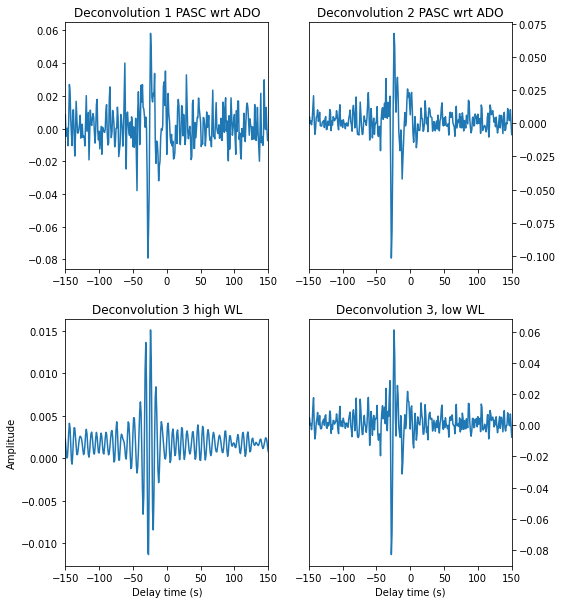

In [8]:

# Two water-levels
WL3 = 1e-07
WL4 = 1e-10

# The cross spectrum
Sxy   = fx4*np.conj(fy4)

# Method 1
Tx1   = fx4/fy4
irf1  = np.real(scipy.fft.ifft(Tx1))
irf1  = scipy.fft.ifftshift(irf1)

# Method 2
Tx2   = Sxy/(Py4_smooth[0:npts2])
irf2  = np.real(scipy.fft.ifft(Tx2))
irf2  = scipy.fft.ifftshift(irf2)

# Method 3
Tx3   = Sxy/(Py4_smooth[0:npts2]+WL3)
irf3  = np.real(scipy.fft.ifft(Tx3))
irf3  = scipy.fft.ifftshift(irf3)

# Method 3
Tx4   = Sxy/(Py4_smooth[0:npts2]+WL4)
irf4  = np.real(scipy.fft.ifft(Tx4))
irf4  = scipy.fft.ifftshift(irf4)

irf1_filt = signal.filtfilt(b, a, irf1)
irf2_filt = signal.filtfilt(b, a, irf2)
irf3_filt = signal.filtfilt(b, a, irf3)
irf4_filt = signal.filtfilt(b, a, irf4)

fig = plt.figure(figsize = (8,10))
ax1 = fig.add_subplot(221)
ax1.plot(tdel,irf1)
ax1.set_xlim(-150, 150)
ax1.set_title('Deconvolution 1 PASC wrt ADO');
ax2 = fig.add_subplot(222)
ax2.plot(tdel,irf2)
ax2.set_xlim(-150, 150)
ax2.set_title('Deconvolution 2 PASC wrt ADO');
ax2.yaxis.tick_right()
ax3 = fig.add_subplot(223)
ax3.plot(tdel,irf3)
ax3.set_xlim(-150, 150)
ax3.set_xlabel('Delay time (s)');
ax3.set_ylabel('Amplitude');
ax3.set_title('Deconvolution 3 high WL');
ax4 = fig.add_subplot(224)
ax4.plot(tdel,irf4)
ax4.set_xlim(-150, 150)
ax4.set_xlabel('Delay time (s)');
ax4.set_title('Deconvolution 3, low WL');
ax4.yaxis.tick_right()

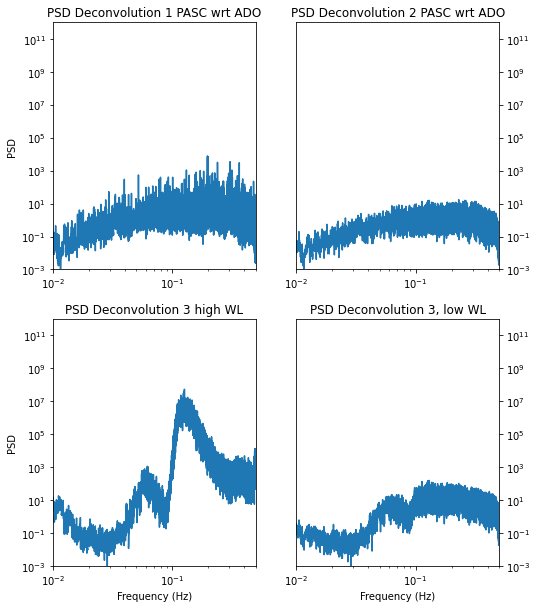

In [9]:
ft_irf1  = scipy.fft.fft(irf1,npts2)
ft_irf1  = abs(ft_irf1)**2
irf1_smooth = np.convolve(ft_irf1, np.ones(nsmooth)/nsmooth)

ft_irf2  = scipy.fft.fft(irf2,npts2)
ft_irf2  = abs(ft_irf2)**2
irf2_smooth = np.convolve(ft_irf2, np.ones(nsmooth)/nsmooth)

ft_irf3  = scipy.fft.fft(irf3,npts2)
ft_irf3  = abs(ft_irf3)**2
irf3_smooth = np.convolve(ft_irf3, np.ones(nsmooth)/nsmooth)

ft_irf4  = scipy.fft.fft(irf4,npts2)
ft_irf4  = abs(ft_irf4)**2
irf4_smooth = np.convolve(ft_irf4, np.ones(nsmooth)/nsmooth)

fig = plt.figure(figsize = (8,10))
ax1 = fig.add_subplot(221)
ax1.loglog(abs(freq4[0:nf4]),irf1_smooth[0:nf4])
ax2 = fig.add_subplot(222)
ax2.loglog(abs(freq4[0:nf4]),irf2_smooth[0:nf4])
ax3 = fig.add_subplot(223)
ax3.loglog(abs(freq4[0:nf4]),irf3_smooth[0:nf4]*1e7)
ax4 = fig.add_subplot(224)
ax4.loglog(abs(freq4[0:nf4]),irf4_smooth[0:nf4]*10)
ax1.set_ylim(1e-3, 1e12);
ax2.set_ylim(1e-3, 1e12);
ax3.set_ylim(1e-3, 1e12);
ax4.set_ylim(1e-3, 1e12);
ax1.set_xlim(0.01, 0.5);
ax2.set_xlim(0.01, 0.5);
ax3.set_xlim(0.01, 0.5);
ax4.set_xlim(0.01, 0.5);
ax3.set_xlabel('Frequency (Hz)');
ax4.set_xlabel('Frequency (Hz)');
ax1.set_ylabel('PSD');
ax3.set_ylabel('PSD');
ax2.yaxis.tick_right()
ax4.yaxis.tick_right()
ax1.set_title('PSD Deconvolution 1 PASC wrt ADO');
ax2.set_title('PSD Deconvolution 2 PASC wrt ADO');
ax3.set_title('PSD Deconvolution 3 high WL');
ax4.set_title('PSD Deconvolution 3, low WL');

## Example 5. Source spectrum and spectral ratio

- Estimate the amplitude spectrum of the recorded $P$ or $S$ waves.
- Perform a spectral ratio, to estimate source properties. 

#### The dataset
On december 24th, 2019 at 12:00 local time a M6.0 earthquake occurred in Eastern Colombia. A M5.8 earthqauke followed 15 minutes later. I was having lunch with my family. 

The next day, 2:00 am UTC time, a M4.7 aftershock was also recorded. 

You should have access to the data ``mesetas1.mseed`` and ``mesetas2.mseed`` thru Slack, but if not, just remove comments to download the data.Data is in instrument corrected to velocity.

#### The theory

This is clearly a very quick review of earthquake source spectrum estimation. There are many studies dealing with this issue. 

The recorded seismic signal from an earthquake $i$ at a seismic station $j$ (for example a $P$ or $S$ wave)  can be described as a convolution 
\begin{equation}
D_{ij} = S_i \ast I_j \ast A_{ij} \ast \cdots 
\end{equation}
where the $I$ term represents the instrument response, the $A$ term the propagation effect (geometrical spreading, attenuation, scattering, etc.) and the $S$ term is the source spectrum (what in this case we are looking to find out. 

Assuming we know both $I$ (possible) and $A$ (less likely), we could in principle estimate the source spectrum. Based on work by Jim Brune and Raul Madariaga, the shape of the source spectrum is parameterized as
\begin{equation}
S(f) = \frac{\Omega_0}{1 + {\left(f/f_c\right)}^2}
\end{equation}
where $\Omega_0$ represents the long-period amplitude and is proportional to the seismic moment $M_0$, and $f_c$ is the corner frequency. With these two parameters, we use models to find the stress drop, the radiated seismic energy, radiation efficiency and many other things. 

Now, the problem is that we do not know $A_{ij}$ very well. Sometimes, we use small earthquakes as Empirical Green's functions to remove the propagation effects, if both the large and the small events are closely located some terms are the same
\begin{equation}
E_{ij} = G_i \ast I_j \ast A_{ij} \ast \cdots 
\end{equation}
\begin{equation}
G(f) = \frac{\Omega^G_0}{1 + {\left(f/f^G_c\right)}^2}
\end{equation}
Taking the spectral ratio
\begin{equation}
R(f) =\frac{S(f)}{G(f)} = \frac{\Omega_0}{\Omega_0^G} \frac{1 + {\left(f/f^G_c\right)}^2}{1 + {\left(f/f_c\right)}^2}
\end{equation}
and the propagation, instrument response and other similar terms are canceled out. Now, you can use the observed spectral ratio to find the moment ratio and the two corner frequencies. 



#### Get the data, for the three events 

In [10]:
# Edit client to use your data center of interest
#client = Client("IRIS")
#t1 = obspy.UTCDateTime("2019-12-24:19:00")
#starttime = t1
#endtime = t1 + 1*60*60  # 1 hour of data
#net = "CM"
#sta = "RUS"
#loc = "*"
#chan = "BHZ"
#st1 = client.get_waveforms(net, sta, loc, chan, starttime, endtime, attach_response = True)
#st1.remove_response(output = 'VEL')
#st1.write("mesetas1.mseed",  format="MSEED")  

#t1 = obspy.UTCDateTime("2019-12-25:02:00")
#starttime = t1
#endtime = t1 + 1*60*60  # 1 hour of data
#net = "CM"
#sta = "RUS"
#loc = "*"
#chan = "BHZ"
#st2 = client.get_waveforms(net, sta, loc, chan, starttime, endtime, attach_response = True)
#st2.remove_response(output = 'VEL')
#st2.write("mesetas2.mseed", format="MSEED")  

st1 = obspy.read('mesetas1.mseed')
st2 = obspy.read('mesetas2.mseed')

print(st1)
print(st2)


1 Trace(s) in Stream:
CM.RUS.00.BHZ | 2019-12-24T19:00:00.019538Z - 2019-12-24T19:59:59.969538Z | 20.0 Hz, 72000 samples
1 Trace(s) in Stream:
CM.RUS.00.BHZ | 2019-12-25T02:00:00.019538Z - 2019-12-25T02:59:59.969538Z | 20.0 Hz, 72000 samples


### Plot the traces

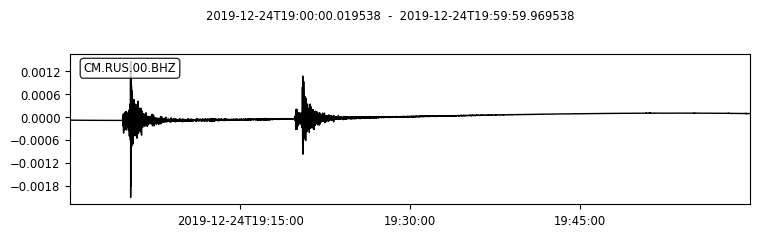

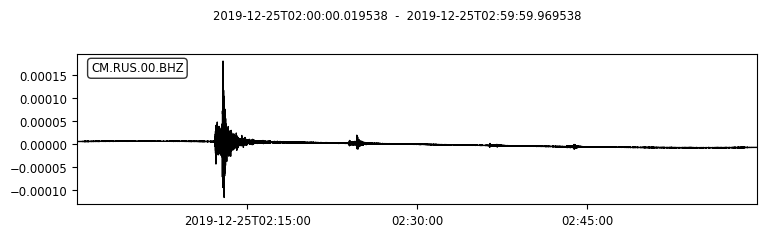

In [11]:
tr1  = st1[0]
tr2  = st2[0] 

tr1.plot()
tr2.plot()

### Extract or window the $P$ and $S$ wave trains for the three events

**Do not change**

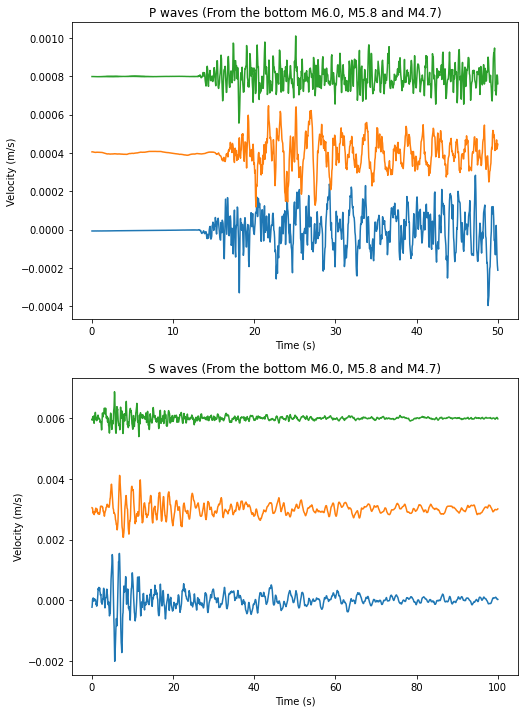

In [15]:
data  = tr1.data
dt    = tr1.stats.delta
tr2   = st2[0];
data2 = tr2.data
dt2    = tr2.stats.delta
npts  = len(data2) 
t2     = np.arange(npts)*dt2

#--------------------------------------------------
# Selected P wave window
#--------------------------------------------------
Pmshock  = signal.detrend(data[5300:6301]);
Pashock  = signal.detrend(data[23500:24501]);
Pashock2 = signal.detrend(data2[14300:15301]) 
t_P      = np.arange(len(Pmshock))*dt

#--------------------------------------------------
# Selected S wave window
#--------------------------------------------------
Smshock  = signal.detrend(data[6300:8301]);
Sashock  = signal.detrend(data[24500:26501]);
Sashock2 = signal.detrend(data2[15300:17301]) 
t_S      = np.arange(len(Smshock))*dt

#---------------------------------------------------
# Plot P waves and S waves
#---------------------------------------------------
fig = plt.figure(figsize = (8,12))
ax = fig.add_subplot(211)
ax.plot(t_P,Pmshock)
ax.plot(t_P,Pashock+0.0004)
ax.plot(t_P,Pashock2*5+0.0008)
ax.set_title('P waves (From the bottom M6.0, M5.8 and M4.7)');
ax.set_xlabel('Time (s)')
ax.set_ylabel('Velocity (m/s)')

ax2 = fig.add_subplot(212)
ax2.plot(t_S,Smshock)
ax2.plot(t_S,Sashock+0.003)
ax2.plot(t_S,Sashock2*5+0.006)
ax2.set_title('S waves (From the bottom M6.0, M5.8 and M4.7)');
ax2.set_xlabel('Time (s)');
ax2.set_ylabel('Velocity (m/s)');

### Work on $P$-wave windows

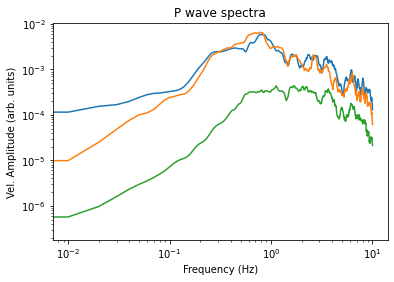

In [16]:
#-----------------------------------------
# Work on P-wave windows
#    Taper signals
#-----------------------------------------
nx      = len(Pmshock)
hann    = np.hanning(nx)
nx2     = 2*nx
x       = np.zeros(nx2)
x[0:nx] = Pmshock*hann
y       = np.zeros(nx2)
y[0:nx] = Pashock*hann
z       = np.zeros(nx2)
z[0:nx] = Pashock2*hann


#-----------------------------------------
# Get Amplitude spectrum
#-----------------------------------------
ft_x  = scipy.fft.rfft(x,nx2)
Pxx   = abs(ft_x)
ft_y  = scipy.fft.rfft(y,nx2)
Pyy   = abs(ft_y)
ft_z  = scipy.fft.rfft(z,nx2)
Pzz   = abs(ft_z)

#------------------------------------------
# Get frequency vector
#------------------------------------------
Pfreq  = scipy.fft.rfftfreq(nx2,dt)
Pnf    = len(Pfreq)

#------------------------------------------
# Smooth spectra
#------------------------------------------
nsmooth = 30
Pxx_smooth = np.convolve(Pxx, np.ones(nsmooth)/nsmooth)
Pyy_smooth = np.convolve(Pyy, np.ones(nsmooth)/nsmooth)
Pzz_smooth = np.convolve(Pzz, np.ones(nsmooth)/nsmooth)

#------------------------------------------
# Plot P spectra for M6.0, M5.8 and M4.7
#------------------------------------------

fig = plt.figure()
ax = fig.add_subplot(111)
ax.loglog(Pfreq,Pxx_smooth[0:Pnf])
ax.loglog(Pfreq,Pyy_smooth[0:Pnf])
ax.loglog(Pfreq,Pzz_smooth[0:Pnf])
ax.set_xlabel('Frequency (Hz)');
ax.set_ylabel('Vel. Amplitude (arb. units)');
ax.set_title('P wave spectra');


### Work on $S$-wave windows

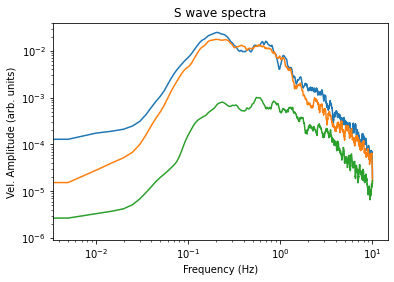

In [17]:
# Taper signals
nx      = len(Smshock)
hann    = np.hanning(nx)
nx2     = 2*nx
x       = np.zeros(nx2)
x[0:nx] = Smshock*hann
y       = np.zeros(nx2)
y[0:nx] = Sashock*hann
z       = np.zeros(nx2)
z[0:nx] = Sashock2*hann

ft_x  = scipy.fft.rfft(x,nx2)
Sxx   = abs(ft_x)
ft_y  = scipy.fft.rfft(y,nx2)
Syy   = abs(ft_y)
ft_z  = scipy.fft.rfft(z,nx2)
Szz   = abs(ft_z)

freq  = scipy.fft.rfftfreq(nx2,dt)
nf    = len(freq)

nsmooth = 30
Sxx_smooth = np.convolve(Sxx, np.ones(nsmooth)/nsmooth)
Syy_smooth = np.convolve(Syy, np.ones(nsmooth)/nsmooth)
Szz_smooth = np.convolve(Szz, np.ones(nsmooth)/nsmooth)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.loglog(freq,Sxx_smooth[0:nf])
ax.loglog(freq,Syy_smooth[0:nf])
ax.loglog(freq,Szz_smooth[0:nf])
ax.set_xlabel('Frequency (Hz)');
ax.set_ylabel('Vel. Amplitude (arb. units)');
ax.set_title('S wave spectra');


### Calculate spectral ratio

Does it look like what we expect? It is not the intention here to find the $f_c$, but one could try and do that here. 

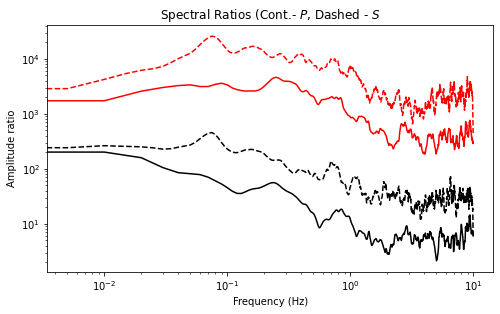

In [18]:
#---------------------------------------
# Plot both spectra ratios
#.  M6.0/M4.7 and M5.8/M4.7
#---------------------------------------

# Plot both spectra ratios

fig = plt.figure(figsize = (8,10))
ax = fig.add_subplot(211)
ax.loglog(Pfreq,Pxx_smooth[0:Pnf]/Pzz_smooth[0:Pnf],'k')
ax.loglog(Pfreq,Pyy_smooth[0:Pnf]/Pzz_smooth[0:Pnf]*100,'r')
#ax2 = fig.add_subplot(212)
ax.loglog(freq,Sxx_smooth[0:nf]/Szz_smooth[0:nf]*5,'k--')
ax.loglog(freq,Syy_smooth[0:nf]/Szz_smooth[0:nf]*100*5,'r--')
ax.set_title('Spectral Ratios (Cont.- $P$, Dashed - $S$')
ax.set_xlabel('Frequency (Hz)');
ax.set_ylabel('Amplitude ratio');